## POSOut

In [12]:
import nltk
tokens = []
sents = []
pos = {}
listOfPos = []
corpusFile = 'assignment1-data/training.en'
with open(corpusFile) as corpus:
    for line in corpus.readlines():
        tokens.append(nltk.word_tokenize(line))
        sents.append(nltk.sent_tokenize(line))
for token in tokens:
    pos.update(nltk.pos_tag(token))

for sent in sents:
    for word in sent:
        pos = []
        pos.append(nltk.pos_tag(word.split()))
        listOfPos.append(pos)

In [31]:
poses = []
for listP in listOfPos:
    for item in listP:
        poses.append([i[1] for i in item])

In [51]:
import random
def pick():
    pick_probability = 0.5
    return random.random() < pick_probability

In [55]:
from collections import defaultdict
posDictOfWords = defaultdict(list)
for sent, pos in zip(sents, poses):
    for word, p in zip(sent[0].split(),pos):
        if not word in posDictOfWords[p]:
            posDictOfWords[p].append(word)

In [21]:
for i in posDictOfWords.keys():
    print(i+' '+str(len(posDictOfWords[i])))

NN 1069
IN 961
DT 844
PRP 393
VBP 293
VBD 154
NNP 572
CD 101
CC 310
MD 236
VB 480
RB 418
TO 339
JJ 659
VBN 273
NNS 432
WDT 105
PDT 21
VBZ 291
EX 42
WP 36
VBG 186
PRP$ 135
RP 42
WRB 69
RBR 21
JJR 39
FW 4
NNPS 29
: 43
. 1
JJS 18
RBS 11
WP$ 4


In [53]:
for sent, pos in zip(sents, poses):
    for word, p in zip(sent[0].split(),pos):
        if pick():
            print(word)
        else:
            print(np.random.choice(posDictOfWords[p], 1))

Resumption
['account']
the
['has']
I
['would']
['detail']
the
['this']
of
['that,']
['Ponnambalam,']
['employment']
['nature']
['is']
['As']
17
['place']
1999,
['we']
['has']
would
like
['gentlemen,']
['has']
to
['I']
you
a
happy
['I']
['points']
['rapporteur']
the
['Commission']
that
you
enjoyed
a
['If']
['to']
period.
['Madam']
['stated']
['extremely']
will
have
seen,
the
["Union'"]
'millennium
['the']
failed
['House']
['should']
still
the
['continue.']
['action']
['a']
number
of
['delay']
suffered
a
series
['but']
natural
disasters
that
['a']
were
['enforcement']
You
['in']
requested
a
['a']
['We']
['As']
['will']
['is']
the
course
of
['period']
['State']
few
['contains']
during
this
['1999']
['transport']
['Mr']
meantime,
I
['rejected']
['number']
to
['wish']
a
['the']
s
['report.']
as
['This']
number
['the']
Members
have
['suddenly']
on
behalf
of
all
the
['stage']
concerned,
['a']
those
of
['safety']
terrible
['my']
['with']
['high']
various
['at']
['this']
the
['rapporteur']
Unio

# Neural network:
Helper algorithms are in the first cell. Second cell has training and generation model. word2vec vectors are used and the number of epochs are set as 33. This number seemed to have a better generation and to avoid moving further to prevent overfitting. Keras is used to complete the model faster.
Sigmoid is used for activation and the movinng average is always kept over the root mean square hence the RMSprop algorithm. Adam can also be used. 

In [336]:
from __future__ import print_function
import numpy as np

def generate_text(model, length, vocab_size, ix_to_char):
    ix = [np.random.randint(vocab_size)]
    y_char = [ix_to_char[ix[-1]]]
    X = np.zeros((1, length, vocab_size))
    for i in range(length):
        X[0, i, :][ix[-1]] = 1
        print(ix_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(ix_to_char[ix[-1]])
    return ('').join(y_char)


def load_data(data_dir, seq_length):
    data = open(data_dir, 'r').read()
    chars = (set(data))
    VOCAB_SIZE = len(chars)

    print('Data length: {} characters'.format(len(data)))
    print('Vocabulary size: {} characters'.format(VOCAB_SIZE))

    ix_to_char = {ix:char for ix, char in enumerate(chars)}
    char_to_ix = {char:ix for ix, char in enumerate(chars)}

    X = np.zeros((int(len(data)/seq_length), seq_length, VOCAB_SIZE))
    y = np.zeros((int(len(data)/seq_length), seq_length, VOCAB_SIZE))
    for i in range(0, int(len(data)/seq_length)):
        X_sequence = data[i*seq_length:(i+1)*seq_length]
        X_sequence_ix = [char_to_ix[value] for value in X_sequence]
        input_sequence = np.zeros((seq_length, VOCAB_SIZE))
        for j in range(seq_length):
            input_sequence[j][X_sequence_ix[j]] = 1.
            X[i] = input_sequence

        y_sequence = data[i*seq_length+1:(i+1)*seq_length+1]
        y_sequence_ix = [char_to_ix[value] for value in y_sequence]
        target_sequence = np.zeros((seq_length, VOCAB_SIZE))
        for j in range(seq_length):
            target_sequence[j][y_sequence_ix[j]] = 1.
            y[i] = target_sequence
    return X, y, VOCAB_SIZE, ix_to_char


In [337]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.layers.wrappers import TimeDistributed

BATCH_SIZE = 50
HIDDEN_DIM = 500
SEQ_LENGTH = 50
WEIGHTS = ''
mode = 'train'
GENERATE_LENGTH = 500
LAYER_NUM = 2

X, y, VOCAB_SIZE, ix_to_char = load_data('assignment1-data/training.en', SEQ_LENGTH)
model = Sequential()
model.add(LSTM(HIDDEN_DIM, input_shape=(None, VOCAB_SIZE), return_sequences=True))
for i in range(LAYER_NUM - 1):
  model.add(LSTM(HIDDEN_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(VOCAB_SIZE)))
model.add(Activation('softmax'))
model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
generate_text(model, 500, VOCAB_SIZE, ix_to_char)
if not WEIGHTS == '':
  model.load_weights(WEIGHTS)
  nb_epoch = int(WEIGHTS[WEIGHTS.rfind('_') + 1:WEIGHTS.find('.')])
else:
  nb_epoch = 0
if mode == 'train' or WEIGHTS == '':
  while nb_epoch<33:
    print('\n\nEpoch: {}\n'.format(nb_epoch))
    model.fit(X, y, batch_size=BATCH_SIZE, verbose=1, nb_epoch=1)
    nb_epoch += 1
    generate_text(model, GENERATE_LENGTH, VOCAB_SIZE, ix_to_char)
    if nb_epoch % 10 == 0:
      model.save_weights('checkpoint_layer_{}_hidden_{}_epoch_{}.hdf5'.format(LAYER_NUM, HIDDEN_DIM, nb_epoch))

elif WEIGHTS == '':
  model.load_weights(WEIGHTS)
  generate_text(model, GENERATE_LENGTH, VOCAB_SIZE, ix_to_char)
  print('\n\n')
else:
  print('\n\nNothing to do!')

Data length: 156902 characters
Vocabulary size: 85 characters
Ué pp%%%%%%%%%BBB888lllllááttttWWW9999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999

Epoch: 0



/anaconda/lib/python3.6/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
3138/3138 [==============================] - 78s - loss: 3.1979    
p    t   e                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Epoch: 1

Epoch 1/1
3138/3138 [==============================] - 299s - loss: 2.8484   
'  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the t

KeyboardInterrupt: 

# Perplexity algorithm:

In [292]:
import math
def perplexity(lines, model=''):
    doc_length = 0
    total_log_sum = 0
    probability = 0
    perplexity = 0
    line_perplexities = []
    for line in lines:
#         line_perplexity = 0
        for char_index in range(len(line) - 2):
#             probability = tri_gram_one[getasciiForSingleChar(line[char_index])][getasciiForSingleChar(line[char_index+1])][getasciiForSingleChar(line[char_index+2])]
            probability = a[getasciiForSingleCharForGiven(line[char_index])][getasciiForSingleCharForGiven(line[char_index+1])][getasciiForSingleCharForGiven(line[char_index+2])]        
            doc_length += 1
            perplexity += math.log(probability, 2)
    perplexity = perplexity / doc_length
    perplexity = math.pow(2, -perplexity)
    print(perplexity)

In [293]:
processed_test_lines = []
list = readFile("test")
for l in list:
    for line in l:
        processed_test_lines.append(process_line(line))
perplexity(processed_test_lines)

22.92785725886985


# ARPA2matrix:
Converting from ARPA to matrix format so that lookup is faster than the arpa format or any other data structures. All the models must be converted to matrix format for computaional comparison. For visual comparison, ARPA should suffice.

In [219]:
def arpa2matrix():
    tri_gram = np.zeros((30,30,30))
    arpa_format = open('model-br.en', 'r').readlines()
    for row in arpa_format:
        sequence = (row[0:3])
        score = float(row[4:13])
        tri_gram[getasciiForSingleChar(sequence[0])][getasciiForSingleChar(sequence[1])][getasciiForSingleChar(sequence[2])] = score
    return tri_gram

In [220]:
tri_gram_from_arpa = arpa2matrix()
print(tri_gram_from_arpa)

[[[  3.33300000e-02   3.33300000e-02   3.33300000e-02 ...,   3.33300000e-02
     3.33300000e-02   3.33300000e-02]
  [  4.20200000e-04   9.70600000e-02   4.24400000e-02 ...,   4.20200000e-04
     4.20200000e-04   4.20200000e-04]
  [  5.75900000e-03   5.23600000e-04   5.75900000e-03 ...,   5.23600000e-04
     5.23600000e-04   5.23600000e-04]
  ..., 
  [  8.85000000e-04   8.85000000e-04   8.85000000e-04 ...,   8.85000000e-04
     8.85000000e-04   9.74300000e-01]
  [  3.33300000e-02   3.33300000e-02   3.33300000e-02 ...,   3.33300000e-02
     3.33300000e-02   3.33300000e-02]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]]

 [[  3.95300000e-04   2.45500000e-01   3.60100000e-01 ...,   3.95300000e-04
     3.95300000e-04   3.95300000e-04]
  [  3.12500000e-03   3.12500000e-03   3.12500000e-03 ...,   3.12500000e-03
     3.12500000e-03   3.12500000e-03]
  [  7.69200000e-03   7.69200000e-03   7.69200000e-03 ...,   7.69200000e-03
  

# Issues with smoothing algorithms:
1. They are not worried about long distant relationships between the characters. For example certain characters (wn) might be conditional on precedinng characters (like wn-3 and wn-5) skipping few grams.
2. It does not carry forward any context variable for a specific sentence or a paragraph.
3. In words language models, the words are not semantically or contextually clustered. This has been resolved by word2vec vectors. Creating a language model over these vectors in a might give us lot of information about a sentence while generating sequences from the model.
4. Also on multiple iterations, the LSTM model seems to have promising text generation. But the training is time consuming. But the model outputs perfect english text.

In [324]:
def model_from_qn1():
    a = np.zeros((3,3,3))
    a[0][0][0] = 0.4
    a[0][0][1] = 0.5
    a[0][0][2] = 0.1
    a[0][1][0] = 0.6
    a[0][1][1] = 0.3
    a[0][1][2] = 0.1
    a[1][1][0] = 0.5
    a[1][1][1] = 0.4
    a[1][1][2] = 0.1
    a[1][0][0] = 0.25
    a[1][0][1] = 0.65
    a[1][0][2] = 0.1
    a[2][2][0] = 0.2
    a[2][2][1] = 0.8
    a[2][2][2] = 0.0
    a[2][0][0] = 0.2
    a[2][0][1] = 0.7
    a[2][0][2] = 0.1
    a[2][1][0] = 0.15
    a[2][1][1] = 0.75
    a[2][1][2] = 0.1


In [83]:
np.log2(0.2)+

-2.3219280948873622

In [84]:
def getasciiForSingleCharForGiven(character):
    char = ord(character)%97
    if char == 35:
        char = 2
    return char

# Preprocessing:
Here, we have used regular expressions to remove the unwanted characters instead of a for loop, which will reduce the number of computations made while removing such characters. 

In [297]:
import numpy as np
import re, os, pygtrie, numbers
dimension = 30
def readFile(path):
    list = []
    input = open(path, 'r')
    list.append(input.readlines())
    return(list)
def process_line(string):
    string = re.sub(r'[^A-Za-z0-9\ \.]', "", string)
    string = re.sub('[0-9]', "0",string)
    string = string.lower()
    string = "##" + string + "#"
    return(string)
processed_lines = []
list = readFile("training.es")
for l in list:
    for line in l:
        processed_lines.append(process_line(line))
#     print('-------------------')
# print(processed_lines)
# for processed_line in processed_lines:
print(processed_lines[0])

triGram = np.zeros((30,30,30))
# print(processed_lines)
for processed_line in processed_lines:
    constructTriGram(processed_line.strip(' ')) # shift it from the for above
print('done')

##reanudacin del perodo de sesiones#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
#c#
#.#
done


# Bridge function:
Bridging function to function for entering trigram sequences from line.

In [1]:
def constructTriGram(line):
    length = len(line)
    listOfGrams = []
    for i in range(length):
        c = []
        if i is 0 or i is 1:
            continue
        else:
            enterSequence(line[i-2:i+1])

# char2matrix function:
characters are being converted to ascii values and scaled within 29 so that these values can be used as indices for the trigram and tricount matrix. Certain unviable sequences are restricted to pass through the loops for counts.

In [2]:
def enterSequence(sequence):
    seq=[]
    seq.append(ord(sequence[0])%97)
    seq.append(ord(sequence[1])%97)
    seq.append(ord(sequence[2])%97)
    seq = getascii(seq)
    i = seq[0]
    j = seq[1]
    k = seq[2]
    if ((i == 29 and j == 29 and k == 29)):
        print('###')
        print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
    elif (j == 29 and k == 29):
        print('c##')
        print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
    elif (i == 29 and k == 29):
        print('#c#')
        print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
    elif (i == 29 and k == 29 and j!=29):
        print('#c#')
        print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
    elif (i != 29 and j == 29 and k!=29):
        print('c#c')
        print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
    else:
        triGram[i][j][k] += 1

# ascii conversion tools (trigram & character):
ascii values are divided by 97 which is the ascii value of 'a' to scale all down within 0 to 26 for alphabets and other characters scaled down appropriately.

Decoding algorithm is at the bottom of this section.

In [3]:
def getascii(seq):
    for i in range(len(seq)):
        if seq[i] == 32:
            seq[i] = 26
        if seq[i] == 46:
            seq[i] = 27
        if seq[i] == 48:
            seq[i] = 28
        if seq[i] == 35:
            seq[i] = 29
    return seq

In [4]:
def getasciiForSingleChar(character):
    char = ord(character)%97
    if char == 32:
        char = 26
    if char == 46:
        char = 27
    if char == 48:
        char = 28
    if char == 35:
        char = 29
    return char

In [357]:
def asciiToChars(value):
    char =''
    if value < 26:
        char = chr(int(value+97))
    elif value == 26:
        char = ' '
    elif value == 27:
        char = '.'
    elif value == 28:
        char = '0'
    elif value == 29:
        char = '#'
    elif value == 30:
        char = '\n'
    return char

# Grams for readability.
Bigrams and unigrams matrices are made for readability. Actually matrices are chosen in this assignment so that bigrams and unigrams can be derived from the trigram matrix itself. This strategy is used having the space complexity in mind. This will reduce (vocabulary * vocabulary + vocabulary) memory blocks.

For instance:
bi_gram[char1][char2] = sum(tri_gram[char1][char2])
The idea is to not use these exclusive bi_gram or uni_gram matrices ,rather we can use tri_gram matrices itself to derive the other matrices without allocating any memory to those. Matrices are chose over dictionaries and hashmaps for this reason.

In [6]:
def getBigram(freq_matrix):
    bi_grams = np.zeros((dimension,dimension))
    for i in range(dimension):
        for j in range(dimension):
            bi_grams[i][j] = sum(freq_matrix[i][j])
    return(bi_grams)

In [7]:
def getUnigram(bi_grams):
    uni_grams = np.zeros((dimension))
    for i in range(dimension):
        uni_grams[i] = sum(bi_grams[i])
    return(uni_grams)

# Data split for training and test data.
80% of the data is used for tarining and final 20% is used as developmental set to find alpha values if Good turing was used. To get hold of the context of the corpus all over, we are stratifying (juggling) the data to get the sentence of every part of the corpus.

In [8]:
def getTrainAndTestData(corpus, dev_part):
    length = len(corpus)
    folded_data = []
    folds = 5
    fold = int(length/5)
    start = 0
    print(fold)
    for i in range(len(corpus)):
        if (i%fold == 0):
            folded_data.append(corpus[start:i])
            start = i
    print(folded_data)
    dev = folded_data[dev_part]
    train = folded_data.pop(dev_part)
    print(dev)
    print('---')
    print(train)

In [9]:
getTrainAndTestData("Here we go, I am just checking",1)

6
['', 'Here w', 'e go, ', 'I am j', 'ust ch']
Here w
---
Here w


In [10]:
from nltk.tokenize import sent_tokenize
def getStratifiedSamplingOfData(corpus, dev_part):
    sent_list = sent_tokenize(corpus)
    train_data = []
    test_data = []
    for i in range(len(sent_list)):
        if i%5 == 0:
            test_data.append(sent_list[i])
        else:
            train_data.append(sent_list[i])
    print(train_data) 

In [11]:
whichPart = 0
corpus = "this’s a sent tokenize test. this is sent two. is this sent three? sent 4 is cool! Now it’s your turn."
getStratifiedSamplingOfData(corpus, whichPart)

['this is sent two.', 'is this sent three?', 'sent 4 is cool!', 'Now it’s your turn.']


# Add alpha smoothing:
pass 1 as the parameter of 'function generateAddOneSmoothing()' to get add 1 smoothing. 0 < alpha < 1

In [298]:
def generateAddOneSmoothing(alpha):
    tri_gram_add_one = np.zeros((dimension, dimension, dimension))
    for w1 in range(dimension):
        for w2 in range(dimension):
            for w3 in range(dimension):
                tri_gram_add_one[w1][w2][w3] = ((triGram[w1][w2][w3] + alpha) / (sum(triGram[w1][w2]) + (alpha*(dimension))))
    return(tri_gram_add_one)

In [299]:
tri_gram_one = generateAddOneSmoothing(1)

# ARPA creation:
Craete ARPA format of the language model to compare.

# Assignment:
The above are the helper functions. To generate models, text annd perplexity for every language. Use following cells to implement those.


## Question 1:
We are asked to calculate the perplexity of the sequence ##abaab#. We use the the given trigram probabilities below which are written as P(ci| ci-2, ci-1):

P(a|##) = 0.2		P(b|#a) = 0.7		P(a|ab) = 0.6


P(a|ba) = 0.25		P(b|aa) = 0.5		P(#|ab) = 0.1


Typically an entropy equation would be used where there are longer sequences. This is in order to prevent underflow and potential zero figures generated. However due to the small size of the sequence we do no tneed to calculte in log space. Thererfore, to calculate this sequence we used the perplexity equation shown below:

#### general equation - centralize equations

With the given probability values inputed into the above equation we get:



#### applied equation

We take the sixth root over the inverse of the product of the trigram probabilities where six is the sequence length, not including the start of sequence marker '##'. 

This gave us the perplexity value of <b>3.136</b> for sequence "##abaab#" given the model.


## Question 2:


#### comment these
The lines are prefixed with '##' and suffixed with '#' 


In order to generate the frequencies of the starting character we would need to include '##' as the history of the start of sentence character. A # will be needed for the end of sequence which would allow the last two characters to be counted amongst the bigram fequencies.


In [308]:
print(process_line("It's 100% correct!"))
print()

##its 000 correct#



Function 'process_line()' is already declared above, so do nnont uncomment the next cell. 

Only for showcase.

In [ ]:
def process_line(string):
    string = re.sub(r'[^A-Za-z0-9\ \.]', "", string)
    string = re.sub('[0-9]', "0",string)
    string = string.lower()
    string  "##" + string + "#"     #Every sentence is intentionally prefixed and suffixed with ## and # respectively. 
    return(string)

#### Convert em to comments

1. Converted all nnumeric characters to 0.
2. Uniformly lower cased.
3. Only alphanumeric, whitespaces, periods are allowed. Other characters are filtered out.
4. Prefixed and suffixed with ## and #.

## Question 3:

The kind of estimation method used on the model-br.en corpus is most likely Add-k smoothing. Add-k smoothing operates by distributing some probability from high frequency sequences to zero count sequences. One of the indicators of this is the presence of the <i>th</i> bigram in the history of some of the lowest probability trigrams (fig 1.). In English the character sequence 'th' is very common so the frequency will be high. The probability in these low probability trigrams containing 'th' are uniform which would suggest that they all share the same value conditioned on their historys high frequency. This would bring the overall probability value of these trigrams to a very low number. There is also evidence that expected high frequency bigrams such as 'th' have been discounted, bringing it to a lower probability than would be expected (fig 2.).

A final observation is the large amount of trigrams, approximately 12,000, with probability 0.033, which indicates a 1/30 value. This could mean a large amount of the sample space that had zero values in frequency and history before smoothing. This is most likely because the trigrams and bigram histories that have these values are highly unlikely occurrences in English and therefore have zero counts.

We rejected backoffs and interpolation as we could not see any unigram or bigram similarities for improbable sequences (like lkm, lkn, lkd or even l**).

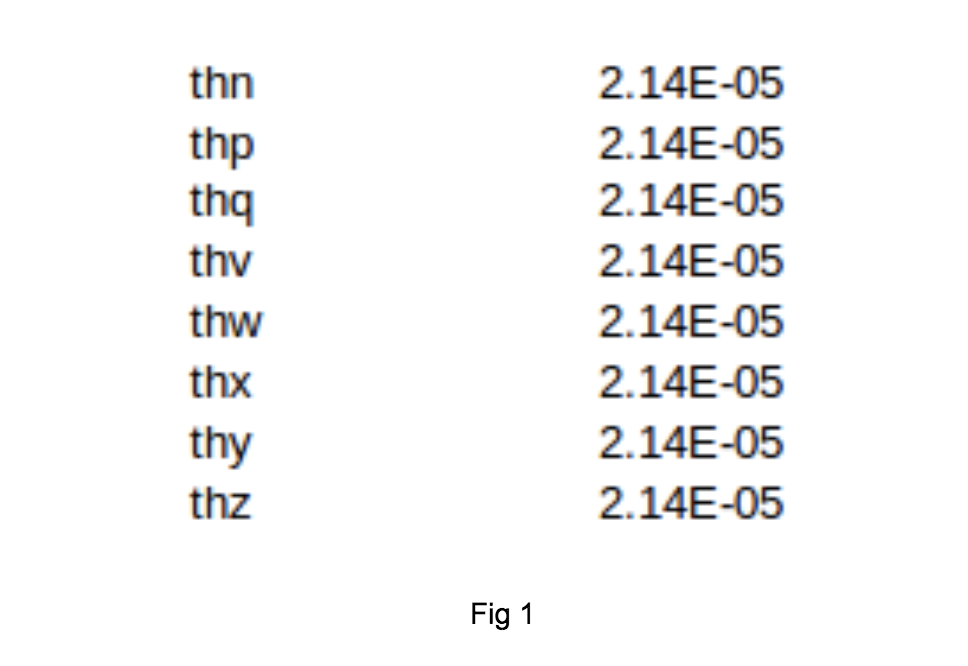

In [314]:
from IPython.display import Image
Image("fig1.png")

## Question 4:


#### Edit
In our assignment we implemented +1 smoothing to generate our probability estimations. Our initial method was Kneser Ney (KN) which proved unsuccessful due to our type of sequences.  KN smoothing conditioned probability on individual character contexts, but given our modification of the training data this would have weighted probability erroneously. We then chose add 1 which allowed us to condition probability on bigram or two character history in a more generalized way. This would better reflect our assumption that the bigram history would condition the trigram or three character sequence to give a better indication of the language specific idiosyncrasies.

Add 1 smoothing is a method used to  account for zero frequency sequences in a given sample space. This estimation method or smoothing allows for the model that the corpus is trained on to be used on other corpus’. This is because sequences not seen in the training corpus have been given some probability and are therefore accounted for when encountered. Conditional probability on which Add 1 is based, requires that the trigram conditional count be divided by the total count of the bigram history. Add 1 is applied as the name suggests by adding one to the total count of a trigram sequence. Due to this increase in counts, the entire vocabulary count is added to the denominaor count to prevent probabilites exceeding 1. The equation below shows how this method is applied:
#### Edit

EQ

Extract of ng character history

The ng sequence is common in Englsih due to the prevalence of the suffixal gerund and present participle form ‘ing’ in written text. Therefore we expect to find a high probability of ng in word final position. This occurs as expected in our model where the trigrams ‘ng ‘ and ‘ng.’ have the some of the highest probabilities. Most consanants following ng have a zero frequency and only receive some probability via smoothing. This is because English rarely allows consonant clusters of three or more that contain ng. Vowels can typically follow consonants and clusters and there is a non normalized probability of different vowels following ng.

### Add an image

##### Data Structure:
We are aware that tries are better for space complexity while storing the ngram models. As we did not have much time to implement a framework of trie for our implementation, we have stored the ngrams in ARPA format. But while choosing a data structure for processing the model on run time, we considered few issues and chose matrix for this particular assingment (char- ngram model)

Actually matrices are chosen in this assignment so that bigrams and unigrams can be derived from the trigram matrix itself. This strategy is used having the space complexity in mind. This will reduce (vocabulary * vocabulary + vocabulary) memory blocks on run time.

For instance:
bi_gram[char1][char2] = sum(tri_gram[char1][char2])
The idea is to not use these exclusive bi_gram or uni_gram matrices ,rather we can use tri_gram matrix itself to derive the other matrices without allocating any memory to those separately. Matrices are chosen over dictionaries and hashmaps for this reason.

## Question 5:

We were asked to write a function that will allow us to generate random 300 character sequences from our Emglish model and the provided Model-br.en. Initially we tried with the most probable value given a bigram sequence. This generation printed out certain sequences that occurred in the training corpus. However due to the high probbility of certain trigrams, some sequences seemed to get repeated. This would even result in a loop generating the most probable sequence. To mitigate this we are picking out the top 3 probable characters given a bigram sequence. Through this weighting process we are randomly generating the next character.


#### Text generated from our English model:

to bus inte truct trult is ands#cal pands.aabin oustakilinte a pans an a pose clembe cating.#calleastakis an oft ofte catingeregregallemempectint trulthint oulan oner struct ouroge ased.bbbc paregivatin to an thint ouregregiourogropment of that tores thingen a sed ans trall ther as ithised an onspos

#### Text generated from model-br.en model:

theresee dad in to yon yoll.#clocl thaing having tay.aaack in ye ton.baby.balich thavin take.#alit ant to yaway whaill ing on.babyeat is tay.ball rinkey he daysee.bboor.aboy.#by.aabble bung talkink yaaby done.bcl thiss.balk.#bund youres takeyeats an thesee ther buir.bace don.bbloodad to yones.#a but

#### Text generated from German model:

darbrin wersicksie ich diesen wersiorsch darbsfhlu st den. alten unse dersicil altereind st en.achtik alegesereindese dest dinen wirdnuter alegterein um so en ue darbstreit einent en din wirts der ang da wententereit er so er so erenten digkalturogentwocil die isserschteregest wer dar andlitt wassca

#### Text generated from Spanish model:

por pase la le se logaralizos daseorancinfriaseo estros elambra la dado.#cultico es didos.#comiste en les das.bca leguisidel por ponen las paseos das.aancluch so el pase enclugerantancio sulticincincios.ableguira de en leste sulas enca legicon los.bbajorale lo ester leste la dela culas pas es pas.#c


To genenerate text from the built model, execute the next cell.

In [328]:
generateAlgo('add_one')
## be sure that you have loaded the trigram already. For a complete demo, use the main code at EOF.

 estadad da dire elas propealicias esidesincluchoyecin eleguiera ca co el directo se sula de los daseos dide la da leguir pria dicar ela ca legiosituros dido.ablame en lamera co dado.bcbbbajanclasegurionale seositado en ele lo eles ponerositos pridelegas dad ester par pa la dad dicarancios.#a desides


To genenerate text from the model given in question one [a,b, #], execute the following cell.

In [330]:
model_from_qn1()
generateAlgo('given_model_1')

 bbccbcabbcaaacbcbcbabbabbccacbacbacbcccbababbaacbaacbcbbbacbcaaabcaabbbbaaacbabaabbccbccbaaacccaabcbaaacacbacacaacaacaaabbaacabbbcbcbccbccabcaacbcbacbbbcbcbabacccacbabcacaabbaabcbbcaaacbcbcbcbaabacacacbabaaacacacacbbacbabbccabbbbacbbaaccaaabcaacbcbccbccacbacbcccaabbaabbbbbbabbbacaabbbbabbbaaabaccbbc


## Question 6:
We test for peplexity using our three models on the provided test set to derive the values:

8.86 for English
22.5 for Spanish
29.2 for German

Given these values it is possible to predict the language of the test corpus. The English model has the lowest perplexity value so its predictions correspond closer to the test set sequencing, which is also in English. This is because there is an negative correlation between perplexity and the conditional probability of a character sequence. The lower the perplexity the higher the conditional probability of a character sequence. A low perplexity value is derived from a test set that has similar characteristics to the training set and is therefore more likely to generate similar sequences.

There are other factors that may affect the perplexity value even within the same language. For example the type of text can influence the value. In both the training and test set a formal report style of writing is used that will characterise the type of vocabulary. If they were different, for example tweets vs legal text, there would be an difference on the character sequence frequencies and thus the probability values, which would be further compounded if our specific stripped down sequence is not tested on. Further testing on a range of Europarl corps’ could reinforce this intuition.

To validate the values of perplexity, we generated text from the given trigram model in question no.1 and passed it to the perplexity algorithm we created. This was done to cross check the value with the value we hand-derived it as it was hinted in the question. We got exactly the same value. 

Also to double-check the value perplexity, we wrote an algorithm to find the entropy and checked its equality by raising its value to the power of 2. They seemed to equate to each other.

Perplexity values are not exactly the same number (precision upto 3). They may vary within a minute range and that is  because of the length of the document (to be specific, the number of sequences the document contain and the repetition of them)


## Question 7:
Kneser Ney

LSTM network

Stratified data or K fold

need not store chars as they are the index

In [374]:
from decimal import Decimal
def createArpa(ext):
    file = open("trigram_add_one."+ext,"w")
    for i in range(30):
        for j in range(30):
            for k in range(30):
                if ((i == 29 and j == 29 and k == 29)):
#                     print('###')
#                     print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
                    continue
                elif (j == 29 and k == 29):
#                     print('c##')
#                     print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
                    continue
                elif (i != 29 and j == 29 and k!=29):
#                     print('c#c')
#                     print(asciiToChars(i)+asciiToChars(j)+asciiToChars(k))
                    continue
                else:
                    s = ""
                    listSeq = []
                    listSeq.append(asciiToChars(i))
                    listSeq.append(asciiToChars(j))
                    listSeq.append(asciiToChars(k))
                    listSeq.append("\t")
                    listSeq.append(str(format_e(tri_gram_one[i][j][k])))
#                     print(tri_gram_one[i][j][k])
                    listSeq.append("\n")
                    file.write(s.join(listSeq)) 
    file.close()



In [375]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

In [376]:
createArpa()

# Text generation algorithm:
To avoid overfitting, we are considering the top 2 values for every possible sequence. So that we dont get the same sequence as we got in the training corpus.

In [372]:
from random import randint
theText = []
def generateText(from_where):
    temp = 0
    first = 29
    second = 29
    theOne = 0
    for i in range(300):
        theOne = randint(0,2)
        if from_where == 'add_one':
            theOne = randint(0,2)
            probableChar = sorted(range(len(tri_gram_one[first][second])), key=lambda i: tri_gram_one[first][second][i], reverse=True)[:3]
        if from_where == 'from_arpa':
            theOne = randint(0,2)
            probableChar = sorted(range(len(tri_gram_from_arpa[first][second])), key=lambda i: tri_gram_from_arpa[first][second][i], reverse=True)[:3]
        if from_where == 'given_model_1':
            first = 2
            second = 2
            theOne = randint(0,2)
            probableChar = sorted(range(len(a[first][second])), key=lambda i: a[first][second][i], reverse=True)[:3]
        theText.append((probableChar[theOne]))
        temp = (probableChar[theOne])
        if temp is 29:
            first = 29
            second = 29
            theText.append(30)
        else:
            first = second
            second = temp
        


In [368]:
def generateAlgo(from_where):
    generateText(from_where) 
    text = ' '
    for i in range(len(theText)):
        text = text + asciiToChars(theText[i])
    print(text)

In [360]:
generateAlgo('from_arpa') # from_arpa # add_one

 ye to yon tak.bbout an yar he done baby was it a dadalice.#
were take.#
yar butty doggy wasee.abbout.bbig.abbirry haild itsit a pager hime.#
wer hainke don.aaack yeah toor.bbig of you lowna pagats.#
wan haveres takit.aaaboure buice.ace.#
wan talike.bbig.aboy wice don havore do ink.#
whatsid tone balkis.#
t


In [373]:
generateAlgo('add_one') 

 su prosidada dir pride el dido da lamosituanclamodos pa delambinfiera dela las encla dicomo susitan logro dicomodicia le en encla cues diciosin dicincaridos dica lo se logas pro socas.#
pa conas didas.#
por entodo encario so su carido didasegicinca cuestadase en les entosidesidos.#
es dad de se seos en


In [371]:
generateAlgo('given_model_1')

 accbaccbacbbbabaacbcbaacacabbbccaacaaacabbacbbabaacbbbaaccccbabaaccabaabcacaaacaabcacbaccabacbbcbbaacacabcbbcbbbcaacbabccccabcacaaacabccccbcbabcabbacabbcacbccbcbbbaaacbaacaaabbaacaacbcacaacbcbacaaccbbbbbcbccbaabbccaabccbbcbbbbcacccaabcbcbccccbacaaabbcaccabcbcacccaabaacbbcccacccaaabbcbbabaccccbabaaca


# Kneser ney smoothing
Kneser ney smoothing actually claimed to be the best language model (except KenLM)

In [ ]:
def generateKNTriGram():
    # D = [0.70, 0.20, 0.10]
    D = 0.75
    charCounts = dimension
    bi_gram_count = getBigram(triGram)
    uni_gram_count = getUnigram(bi_gram_count)
    uni_gram = (uni_gram_count / sum(uni_gram_count))
    bi_gram = np.zeros((dimension,dimension))
    tri_gram = np.zeros((dimension,dimension,dimension))
    for i in range(dimension):
        for j in range(dimension):
            if bi_gram_count[i][j] > 0:
                bi_gram[i][j] = ( (bi_gram_count[i][j] - D) / uni_gram_count[i] ) + (((D * charCounts) / uni_gram_count[i]) * uni_gram[j])
            else:
                bi_gram[i][j] = (((D * charCounts) / uni_gram_count[i]) * uni_gram[j])
                # print(bi_gram)
    for w1 in range(dimension):
        for w2 in range(dimension):
            for w3 in range(dimension):
                if triGram[w1][w2][w3] > 0:
                    tri_gram[w1][w2][w3] = ((triGram[w1][w2][w3] - D) / bi_gram_count[w1][w2]) + ((D * charCounts) / bi_gram_count[w1][w2]) * bi_gram[w2][w3]
                elif bi_gram_count[w1][w2] > 0:
                    tri_gram[w1][w2][w3] = ((D * charCounts) / bi_gram_count[w1][w2]) * bi_gram[w2][w3]
#                 else:
#                     tri_gram[w1][w2][w3] = 
                    ##################### Work in pending #####################
    print(tri_gram)
